# load and visualize models


In [1]:
import torch
from torch.utils import data
import vae
from glob import glob
import numpy as np
import pandas as pd
import time
from vae import PD2_LABEL_COLUMNS, PARTITION_PATH
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
import rqpy as rp
import seaborn as sns
import os
from torchviz import make_dot, make_dot_from_trace

In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


Define Paths

In [3]:
use_cuda

True

In [4]:
basepath = '/gpfs/slac/staas/fs1/supercdms/tf/slac/Run44/models/Run44_short_wiener_trunc/good_triggers_no_low_tight/'
file_mapping = '/gpfs/slac/staas/fs1/supercdms/tf/slac/Run44/Run44_short_wiener/file_mapping.h5'
figsavepath_base = '/gpfs/slac/staas/fs1/supercdms/tf/slac/Run44/model_dev_figs/model_testing/short_wiener_trunc/good_triggers_no_low_tight/'
#model_folder = 'v6_8_flat'  
#model_folder = 'v6_8_flat_beta1'  
#model_folder = '6_dims_beta1'
#########model_folder = '35_dims_beta0_lr1e-3_single_nodrop'
#model_folder = '45_dims_beta1_lr1e-3_single_nodrop'
# model_folder = '45_dims_beta_point025_lr1e-3_nodrop_dif_offset'
# model_folder =  '45_dims_beta_point75_lr1e-3_drop_dif_offset'
# model_folder =  '45_dims_beta_point5_lr1e-3_nodrop_dif_offset_single_k8_s4'
model_folder =  '30_b0_single_s2k3_nodrop'
model_folder =  '25_b_5_s1k3_nodrop'
model_folder =  '25_b_5_s3k9_nodrop'
model_folder =  '25_b_0_s2k8_nodrop_single_sf5'
model_folder =  '25_b_5_s2k8_nodrop_sf5'
model_folder = '25_b_5_s2k8_nodrop_sf5_lr1e2'


#model_folder = 'v6_8_flat_beta10'  
#model_folder = 'v6_8_flat_beta100'  
#model_folder = 'v6_8_flat_beta1e-1' 
#model_folder = 'v6_8_flat_beta1e-2'  
#model_folder = 'v6_8_flat_beta5'  
#model_folder = 'v6_8_flat_beta50'
figsavepath = f'{figsavepath_base}{model_folder}/'



savefigs = True

# make dirs for model to save
isdir = os.path.isdir(figsavepath)
if savefigs:
    if not isdir:
        os.makedirs(figsavepath)

Load partition

In [5]:
partition = vae.io.load_partition(PARTITION_PATH, 'good_triggers_no_low_tight')


In [6]:
len(partition['train'])

8293

Define params

In [7]:
# Parameters
# params = {'batch_size': 64,
#           'shuffle': False,
#           'num_workers': 12, 
#           'pin_memory' : False,
#           'drop_last' : False}

truncate = 812

params = {'batch_size': 128,
          'shuffle': False,
          'num_workers': 10, 
          'pin_memory' : True,
          'drop_last' : False}





settings_path =sorted(glob(f'{basepath}{model_folder}/*.pkl'))
if len(settings_path) > 0:
    
    with open(settings_path[0], 'rb') as thing:
        settings = pkl.load(thing)
    tracelength = settings['tracelength']
    scale_factor = settings['scale_factor']
    offset = settings['offset']
    z_dim = settings['z_hidden']
    model = vae.VAE(z_dim, usedropout_encode=settings['usedropout'], **settings['model_params'])
else:
    ### If the settings we not saved, load these yourself
    tracelength = 1625
    scale_factor = 4e-6
    offset = 0.2
    z_dim = 4

In [8]:
settings['model_params']

{'tracelength': 812,
 'kernels': [8, 8, 8, 8],
 'strides': [2, 2, 2, 2],
 'final_pad': 1,
 'final_kernel': 5}

In [9]:
tracelength

1625

In [10]:
z_dim

25

Load saved model

In [11]:
settings.keys()

dict_keys(['scale_factor', 'offset', 'learning_rate', 'z_hidden', 'beta', 'tracelength', 'usedropout', 'model_params'])

In [12]:
# extra_model_params = {'kernels' : [8]*4,
#                       'strides' : [2]*4, 
#                       'final_pad' : 1,
#                       'final_kernel' : 5}
# z_hidden = 25
# dropout=False

# tracelength = int(1624/2)
# model = vae.VAE(z_hidden, tracelength=tracelength, usedropout_encode=dropout, **extra_model_params).to(device)
### Print model
summary(model, (1, 812))
# summary(model.encoder, (1, 1624))
# summary(model.decoder, (1, z_hidden))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 404]             144
       BatchNorm1d-2              [-1, 16, 404]              32
            Conv1d-3              [-1, 16, 199]           2,064
       BatchNorm1d-4              [-1, 16, 199]              32
            Conv1d-5               [-1, 32, 96]           4,128
       BatchNorm1d-6               [-1, 32, 96]              64
            Conv1d-7               [-1, 32, 45]           8,224
       BatchNorm1d-8               [-1, 32, 45]              64
            Linear-9                   [-1, 64]          92,224
      BatchNorm1d-10                   [-1, 64]             128
           Linear-11                   [-1, 16]           1,040
           Linear-12                   [-1, 25]             425
           Linear-13                   [-1, 25]             425
          Encoder-14       [[-1, 25], [

In [13]:
model_path =sorted(glob(f'{basepath}{model_folder}/*.pt'))[-1]
#model_path = '/gpfs/slac/staas/fs1/supercdms/tf/slac/Run44/models/Run44_short_wiener_trunc/good_triggers_no_low_tight/25_b_5_s2k8_nodrop_single/model_epoch2210.pt'
#model_path ='/gpfs/slac/staas/fs1/supercdms/tf/slac/Run44/models/Run44_short_wiener/good_triggers_no_low_tight/25_b_5_s3k9_nodrop/model_epoch0300.pt'   
#model = vae.VAE(z_dim).to(device)

epochs = int(model_path[-7:-3])
epochs

98

In [14]:
print(model_path)

/gpfs/slac/staas/fs1/supercdms/tf/slac/Run44/models/Run44_short_wiener_trunc/good_triggers_no_low_tight/25_b_5_s2k8_nodrop_sf5_lr1e2/model_epoch0098.pt


Plot loss function

In [15]:
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['state_dict'])

In [16]:
#sns.set_context('poster')

In [17]:
np.min(np.array(checkpoint['loss_val']))

0.5427882769115869

In [18]:
np.argmin(checkpoint['loss_val'])

59

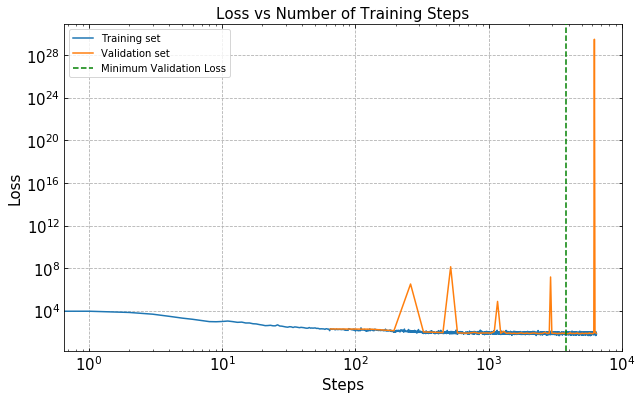

In [19]:
if len(checkpoint['loss_val']) > 0:
    vae.plot_loss(training_loss=checkpoint['loss_train'], 
                  test_loss=np.array(checkpoint['loss_val'])*128, 
                  nper_epoch=len(partition['train'])/128,#len(partition['validation'])/params['batch_size'], 
                  nepochs=epochs, savefig=savefigs, filename=figsavepath+'loss')
else:
    vae.plot_loss(training_loss=checkpoint['loss_train'], savefig=savefigs, filename=figsavepath+'loss')
#plt.ylim(2,10000)
plt.xscale('log')
plt.axvline(np.argmin(checkpoint['loss_val'])*len(partition['train'])/128, 
            linestyle ='--', c='g', label='Minimum Validation Loss', zorder = 200)
plt.legend()

Load data

In [20]:
model_path = '/gpfs/slac/staas/fs1/supercdms/tf/slac/Run44/models/Run44_short_wiener_trunc/good_triggers_no_low_tight/25_b_5_s2k8_nodrop_sf5_lr1e2/model_epoch0059.pt'

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['state_dict'])


In [21]:
# Generators
training_set = vae.PD2dataset(partition['train'], 
                              labels='full',
                              map_path=file_mapping,
                              max_normed=False,
                              baseline_sub=True, 
                              offset=offset,
                              scaledata=scale_factor,
                              tracelength=tracelength,
                              truncate=truncate)
train_loader = data.DataLoader(training_set, **params)

test_set = vae.PD2dataset(partition['validation'], 
                          labels='full', 
                          map_path=file_mapping,
                          max_normed=False, 
                          baseline_sub=True, 
                          offset=offset,
                          scaledata=scale_factor,
                          tracelength=tracelength,
                          truncate=truncate)
test_loader = data.DataLoader(test_set, **params)

Plot a few reconstructed traces

In [22]:
#sns.set_context('poster')

In [23]:
4

4

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f31d2906908>)

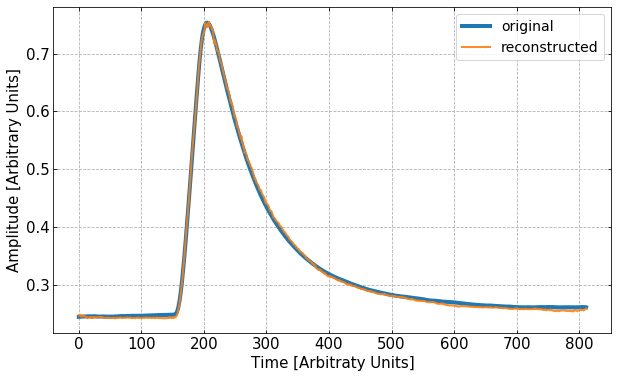

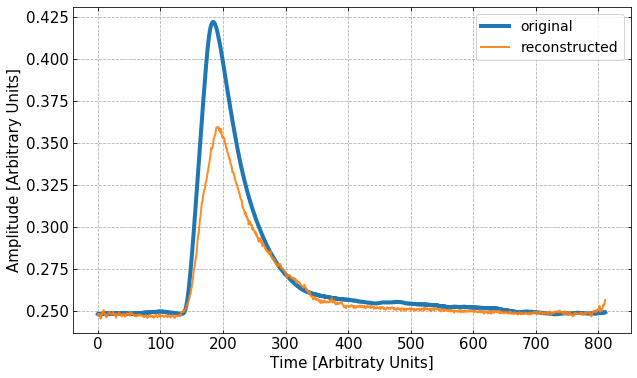

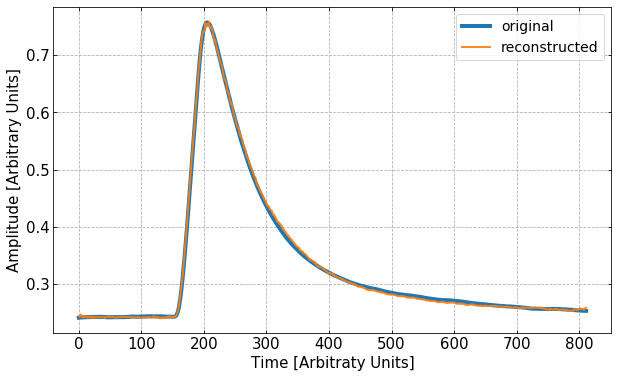

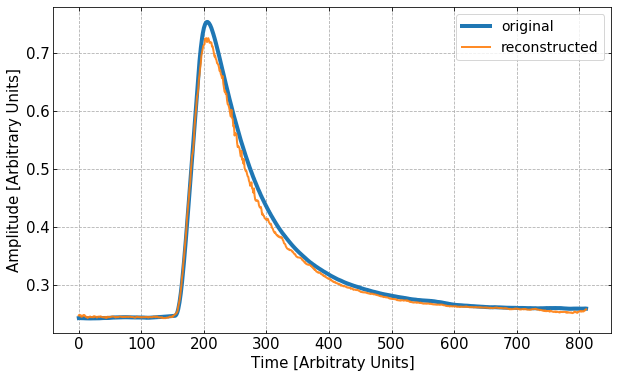

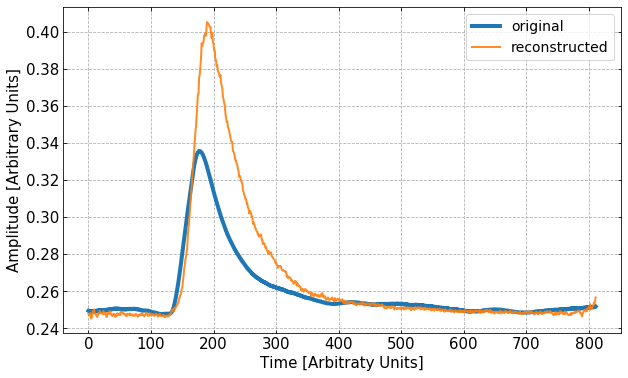

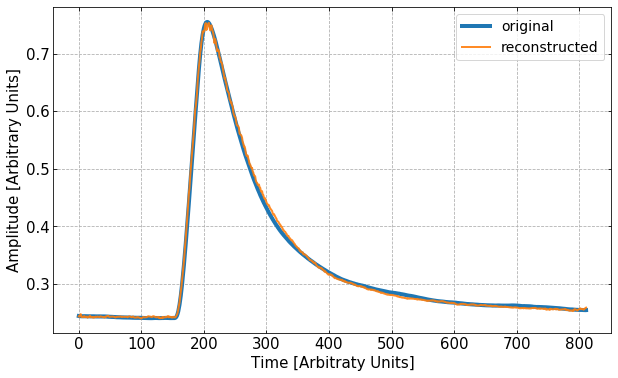

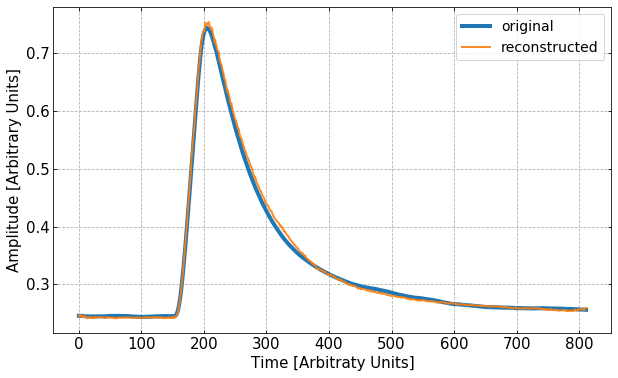

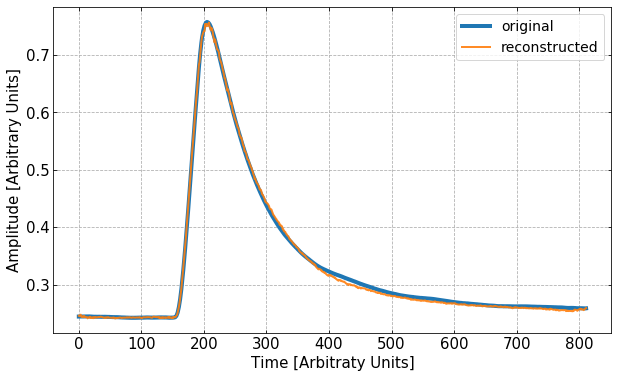

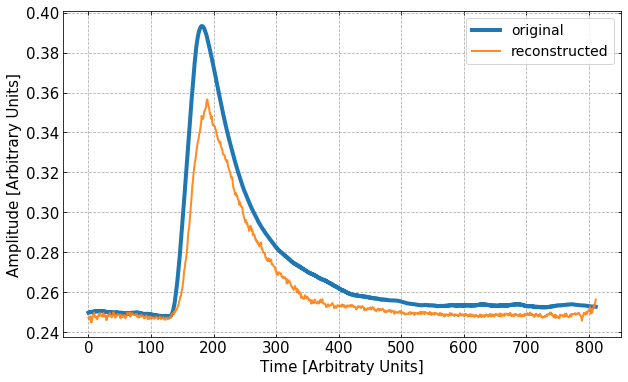

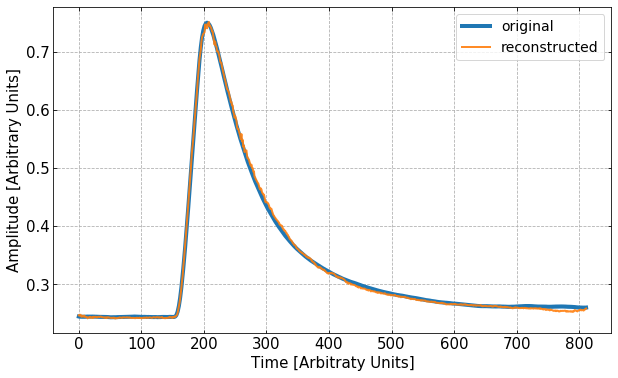

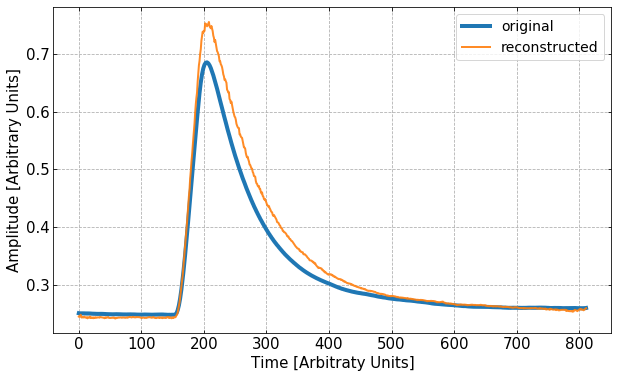

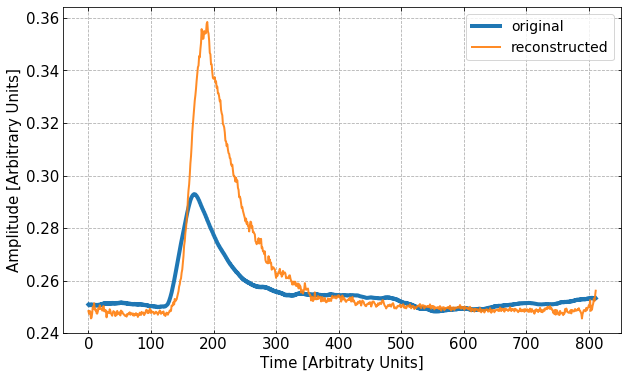

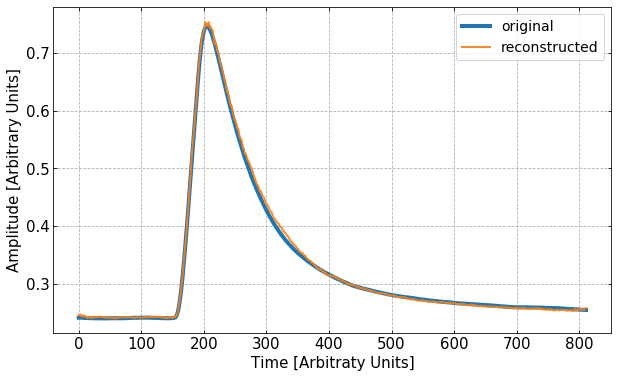

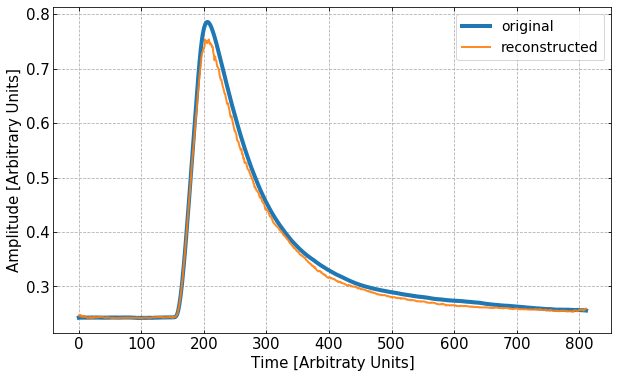

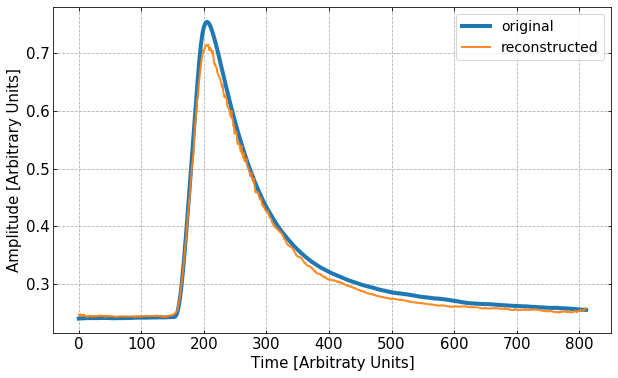

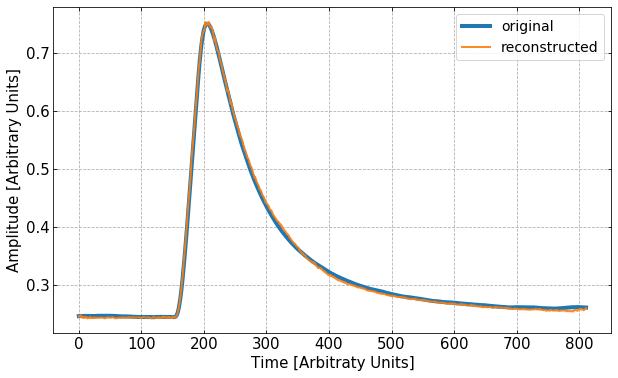

In [24]:

vae.plot_recon(test_loader, model, 16, savefig=savefigs, filename=figsavepath+'recon')

Load latent variables

In [15]:
arr, labels = vae.io.get_latent_vars(train_loader, model, label_rtn=True)


In [34]:
arr_test, labels_test = vae.io.get_latent_vars(test_loader, model, label_rtn=True)

Reduce data with PCA and tSNE

In [16]:
x_pca = vae.utils.reduce_dims(arr, method='PCA')


In [35]:
x_pca_test = vae.utils.reduce_dims(arr_test, method='PCA')

In [30]:
x_tsne = vae.utils.reduce_dims(arr, method='tSNE')


In [20]:
x_tsne_test = vae.utils.reduce_dims(arr_test, method='tSNE')

In [17]:
ind = PD2_LABEL_COLUMNS.index('energy')
ind

103

Visualize latent variables with PCA

(<Figure size 720x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1ea030b898>)

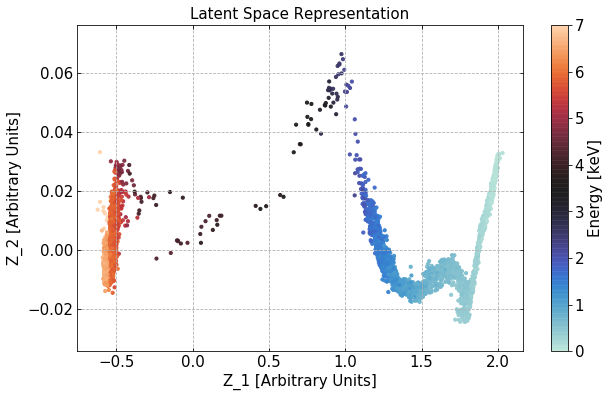

In [19]:
vae.plot_latent_2d(x_pca, labels[:,ind]*1e-3, label_name='Energy [keV]', 
                   pltkwargs={'alpha' : .95, 's' : 10, 'cmap' : 'icefire',  'vmin' : 0, 'vmax' : 7}
                  , savefig=savefigs, filename=figsavepath+'Latent_PCA')


(<Figure size 720x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faa4fc47438>)

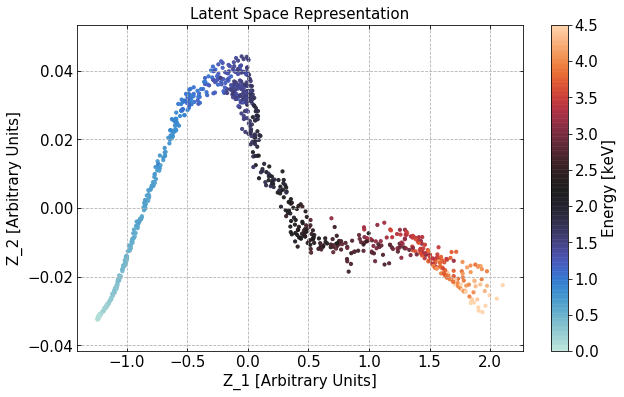

In [36]:
vae.plot_latent_2d(x_pca_test, labels_test[:,ind]*1e-3, label_name='Energy [keV]', 
                   pltkwargs={'alpha' : .95, 's' : 10, 'cmap' : 'icefire',  'vmin' : 0, 'vmax' : 4.5}
                  , savefig=savefigs, filename=figsavepath+'Latent_PCA')

Visualize latent variables with tSNE

(<Figure size 720x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4679a48828>)

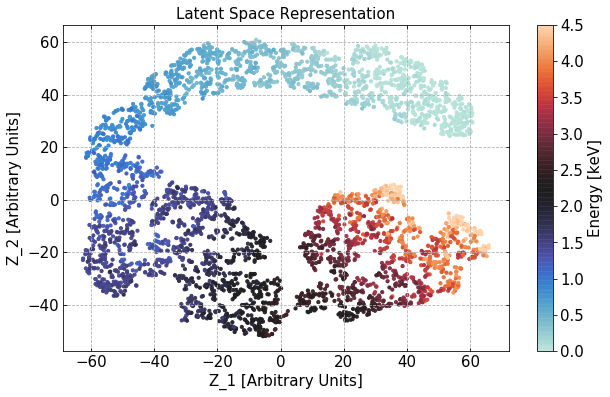

In [32]:
vae.plot_latent_2d(x_tsne, labels[:,ind]*1e-3, label_name='Energy [keV]', 
                   pltkwargs={'alpha' : .95, 's' : 10, 'cmap' : 'icefire',  'vmin' : 0, 'vmax' : 4.5}
                  , savefig=savefigs, filename=figsavepath+'Latent_tSNE')


(<Figure size 720x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4643bbec18>)

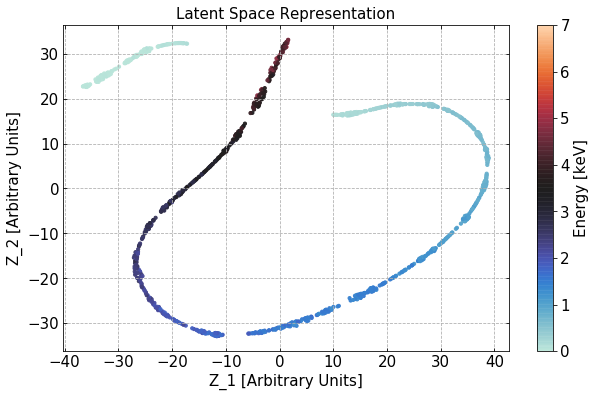

In [33]:
vae.plot_latent_2d(x_tsne_test, labels_test[:,ind]*1e-3, label_name='Energy [keV]', 
                   pltkwargs={'alpha' : .95, 's' : 10, 'cmap' : 'icefire', 'vmin' : 0, 'vmax' : 7}
                  , savefig=savefigs, filename=figsavepath+'Latent_tSNE')

Plot each latent variable vs True Energy

In [38]:
sns.set_context('poster')

In [43]:
PD2_LABEL_COLUMNS

['eventnumber',
 'seriesnumber',
 'eventtime',
 'triggertype',
 'pollingendtime',
 'triggertime',
 'triggeramp',
 'readoutstatusZ1',
 'deadtimeZ1',
 'livetimeZ1',
 'triggervetoreadouttimeZ1',
 'seriestimeZ1',
 'waveformreadendtimeZ1',
 'waveformreadstarttimeZ1',
 'baseline_PDS1Z1',
 'integral_PDS1Z1',
 'energy_absorbed_PDS1Z1',
 'maxmin_PDS1Z1',
 'chi2_nopulse_PDS1Z1',
 'ofamp_nodelay_PDS1Z1',
 'chi2_nodelay_PDS1Z1',
 'ofamp_unconstrain_PDS1Z1',
 't0_unconstrain_PDS1Z1',
 'chi2_unconstrain_PDS1Z1',
 'ofamp_unconstrain_pcon_PDS1Z1',
 't0_unconstrain_pcon_PDS1Z1',
 'chi2_unconstrain_pcon_PDS1Z1',
 'ofamp_constrain_PDS1Z1',
 't0_constrain_PDS1Z1',
 'chi2_constrain_PDS1Z1',
 'ofamp_constrain_pcon_PDS1Z1',
 't0_constrain_pcon_PDS1Z1',
 'chi2_constrain_pcon_PDS1Z1',
 'chi2lowfreq_nodelay_PDS1Z1',
 'chi2lowfreq_unconstrain_PDS1Z1',
 'chi2lowfreq_unconstrain_pcon_PDS1Z1',
 'chi2lowfreq_constrain_PDS1Z1',
 'chi2lowfreq_constrain_pcon_PDS1Z1',
 'ofamp_pileup_PDS1Z1',
 't0_pileup_PDS1Z1',
 'chi2_

In [56]:
ind = PD2_LABEL_COLUMNS.index('oftaufall_nlin_PDS1Z1')
# 'baseline_PDS1Z1'
# 'baseline_PDS1Z1'
# oftaufall_nlin_PDS1Z1

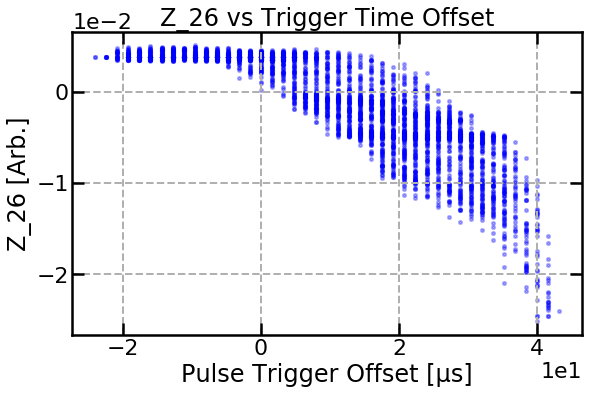

In [55]:
ind = PD2_LABEL_COLUMNS.index('t0_unconstrain_PDS1Z1')
rp.scatter(labels[:, ind]*1e6, arr[:,26], ms=10, lgclegend=False)
plt.xlabel('Pulse Trigger Offset [μs]')
plt.ylabel(f'Z_{26} [Arb.]')
plt.title(f'Z_{26} vs Trigger Time Offset')
plt.tight_layout()

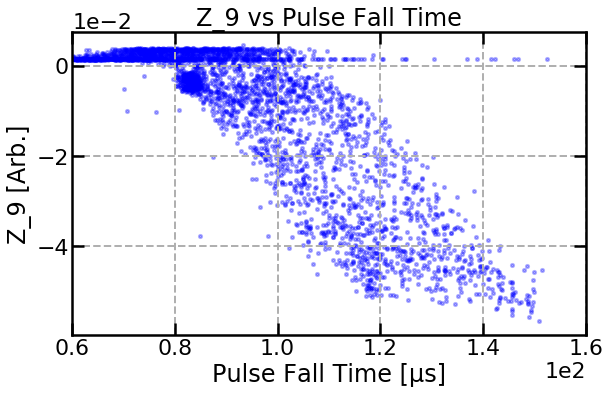

In [64]:
ind = PD2_LABEL_COLUMNS.index('oftaufall_nlin_PDS1Z1')
rp.scatter(labels[:, ind]*1e6, arr[:,9], xlims=(60, 160), ms=10, lgclegend=False)
plt.xlabel('Pulse Fall Time [μs]')
plt.ylabel(f'Z_{9} [Arb.]')
plt.title(f'Z_{9} vs Pulse Fall Time')
plt.tight_layout()

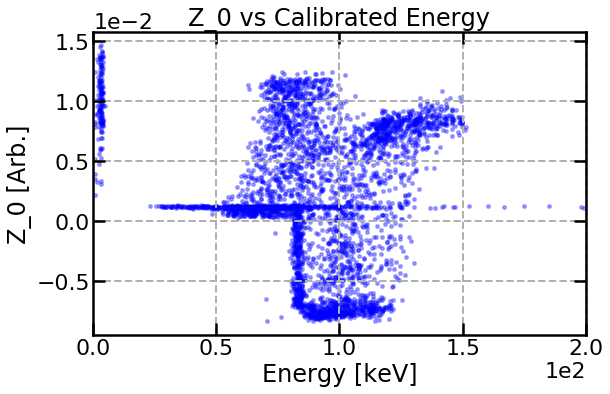

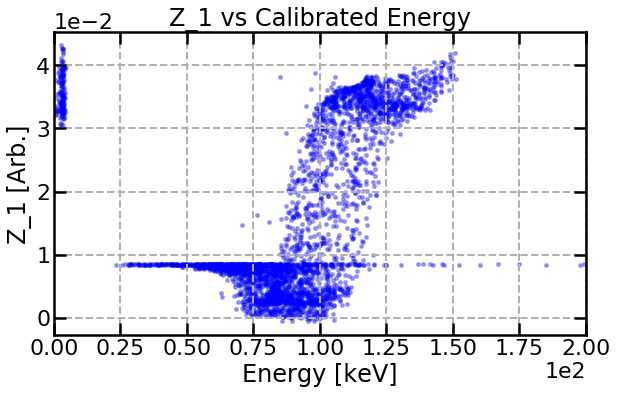

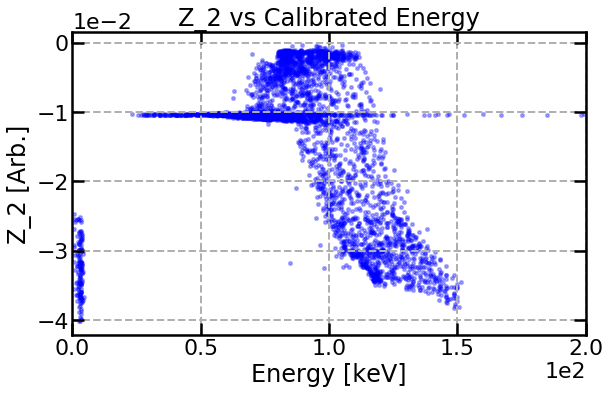

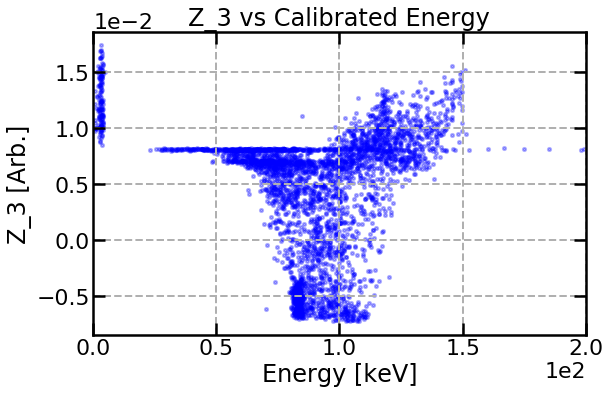

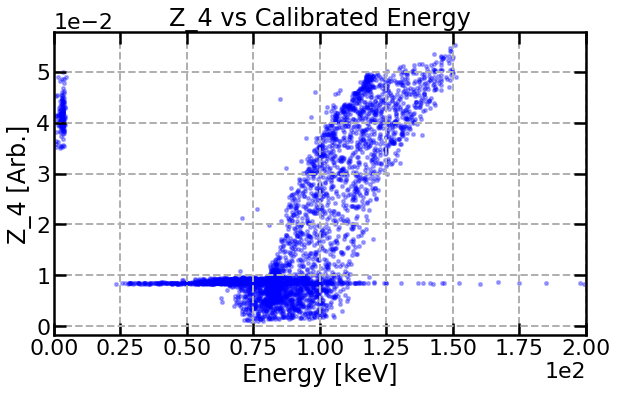

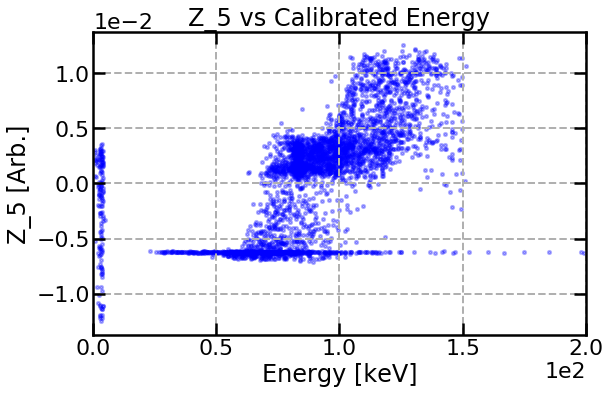

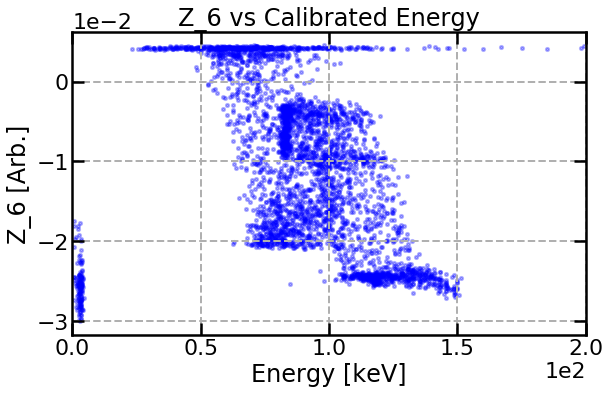

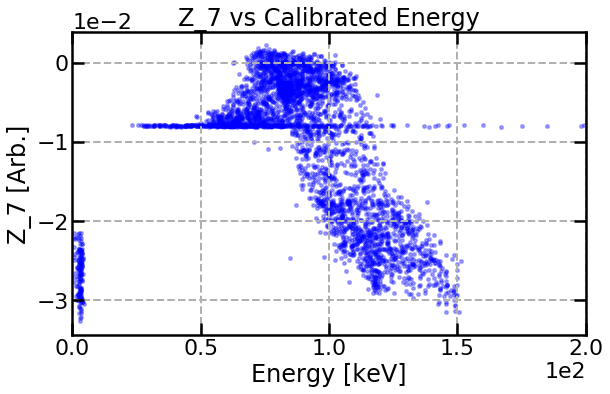

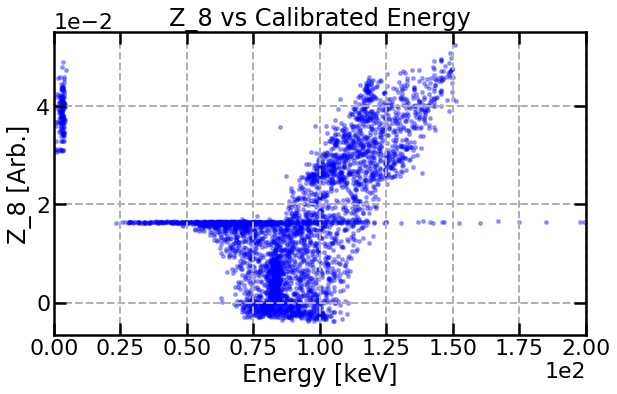

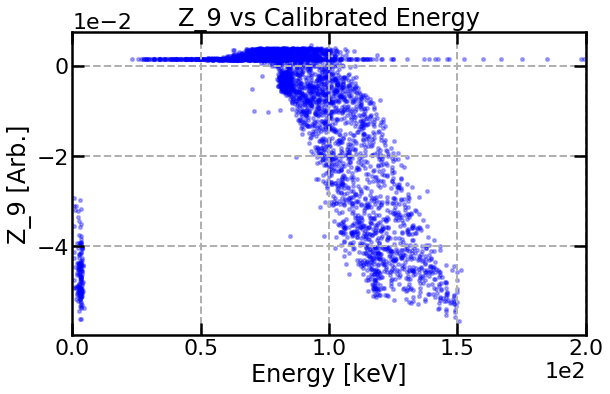

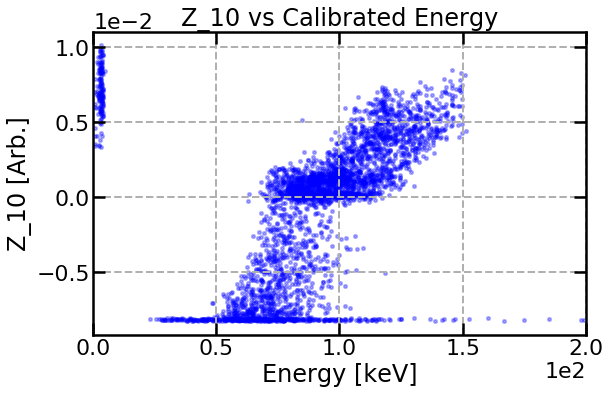

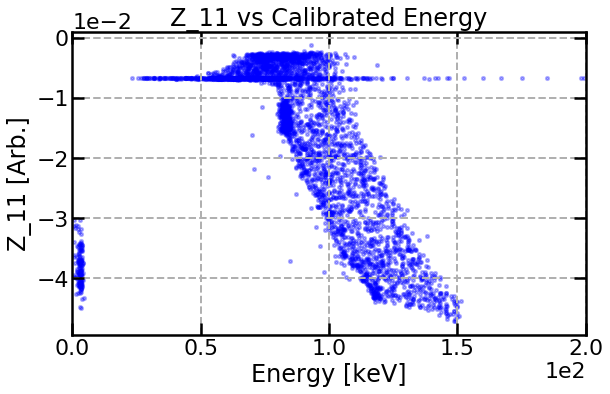

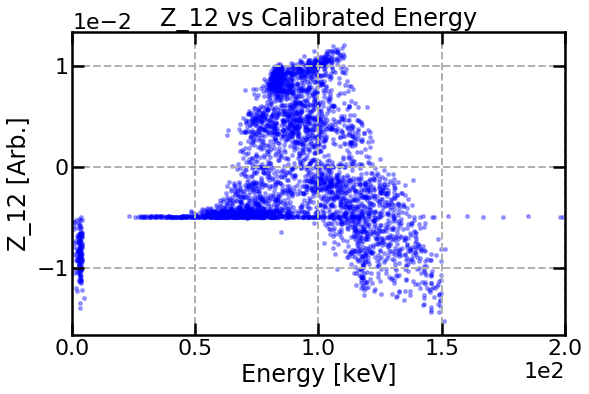

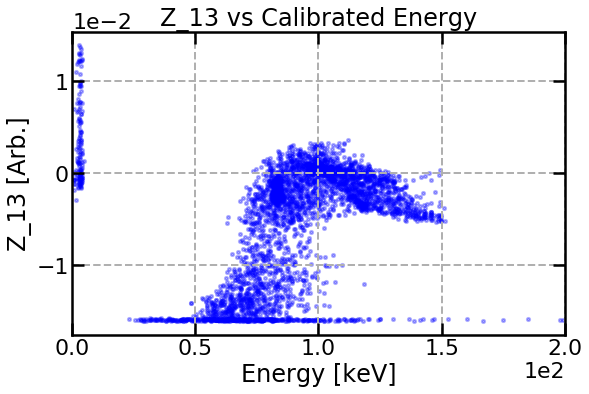

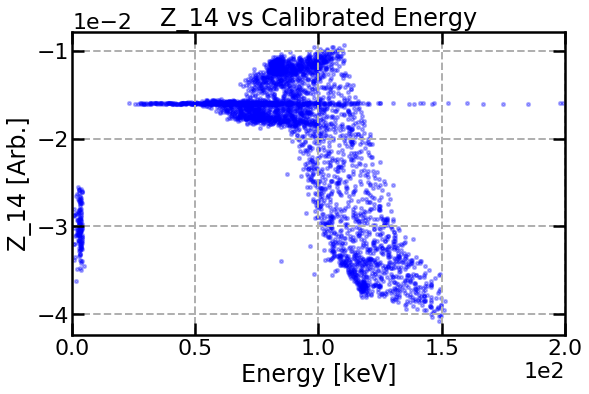

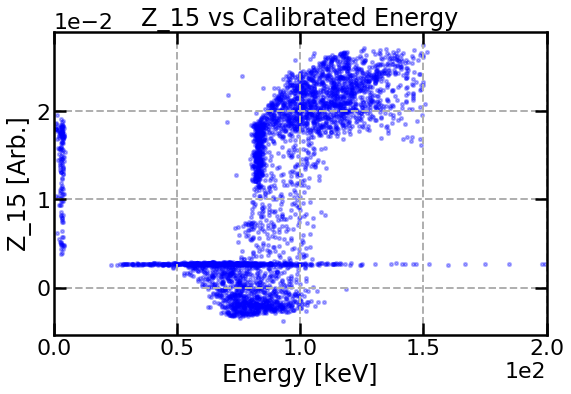

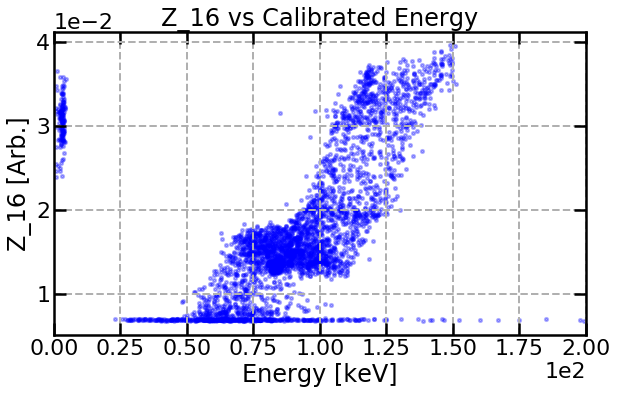

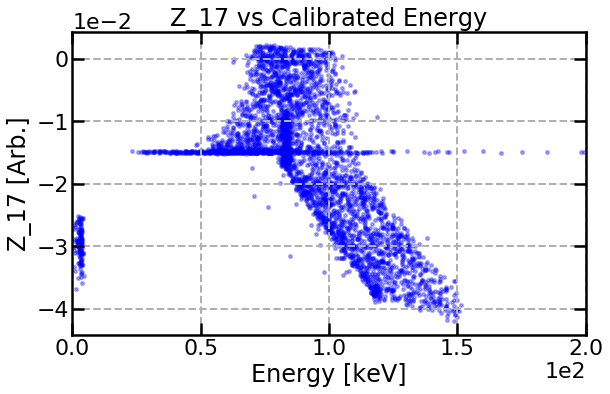

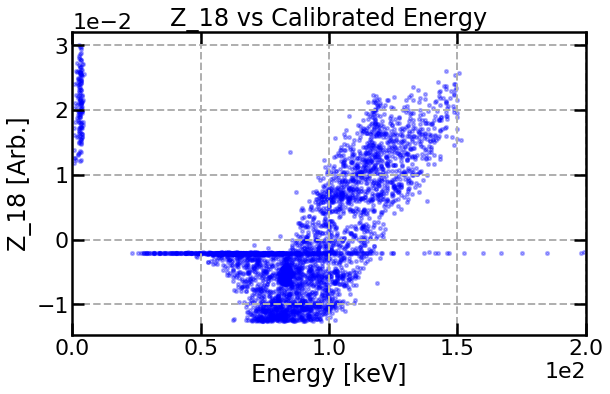

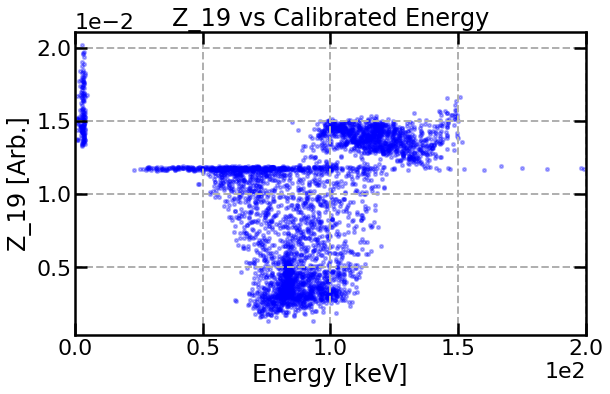

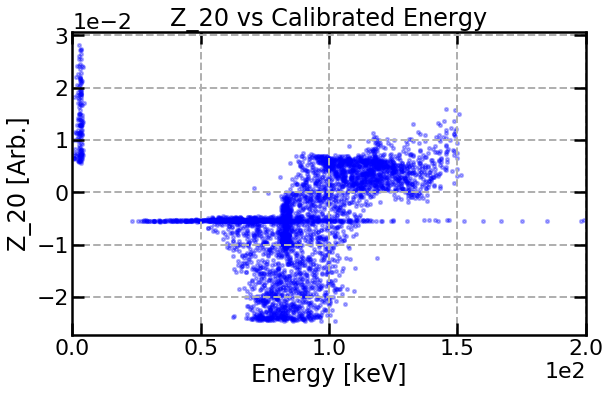

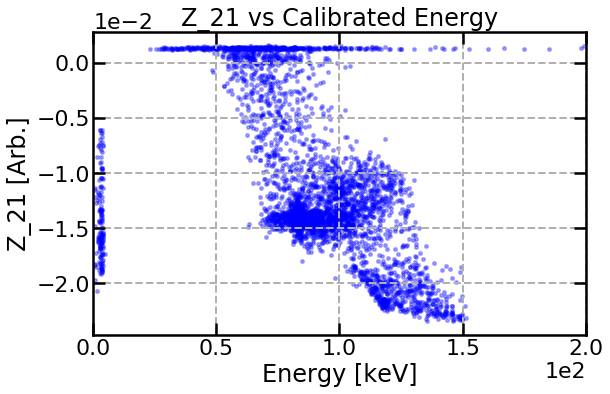

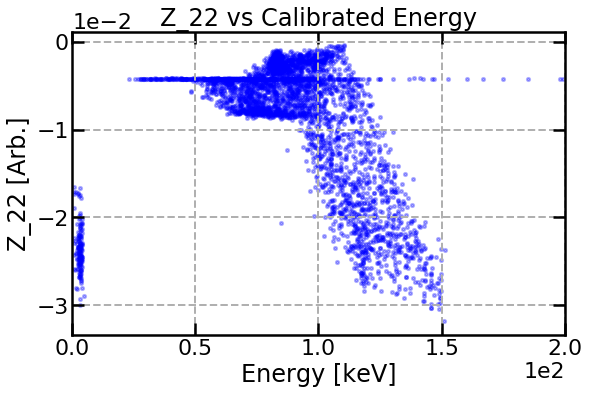

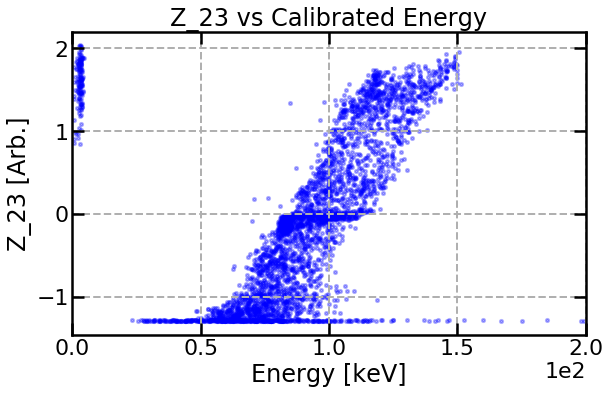

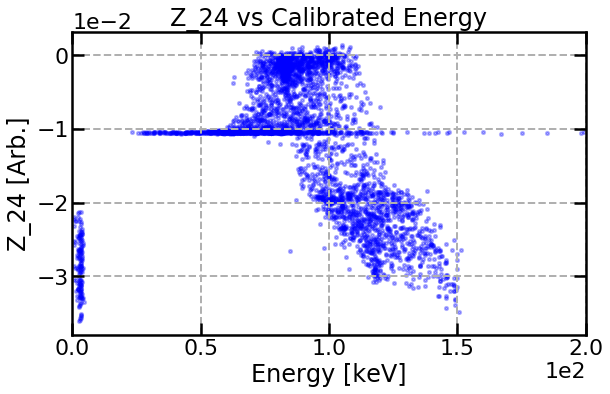

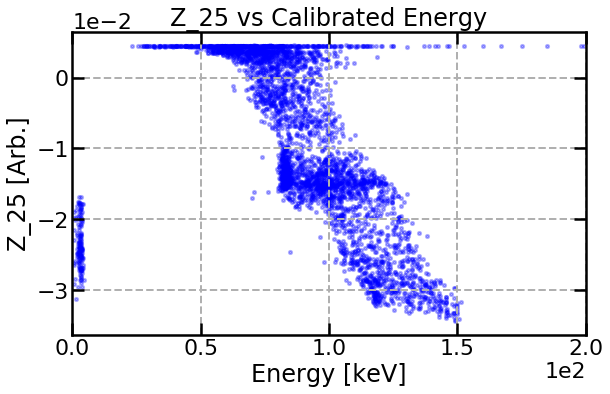

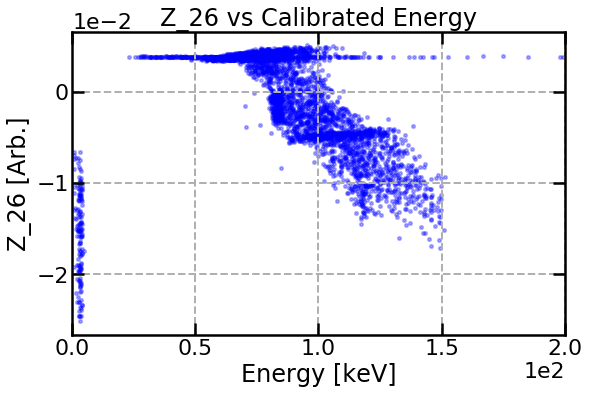

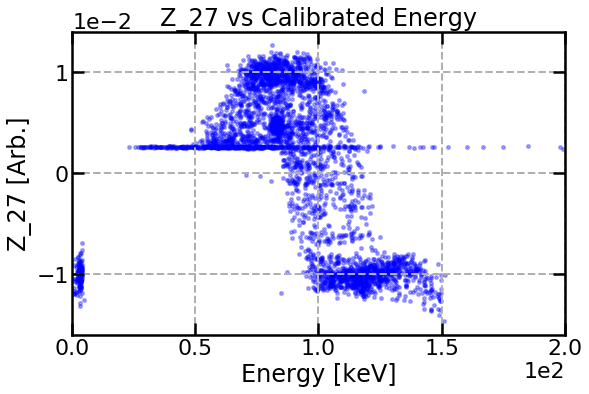

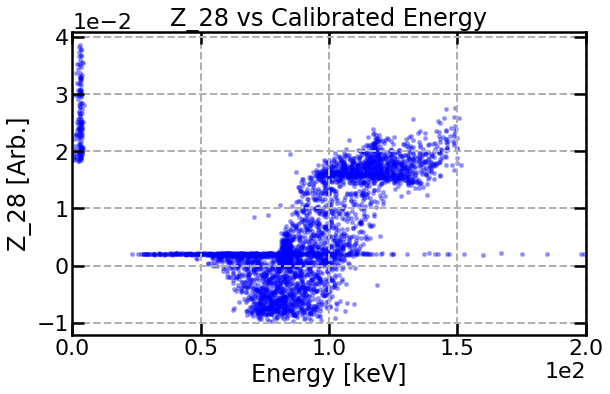

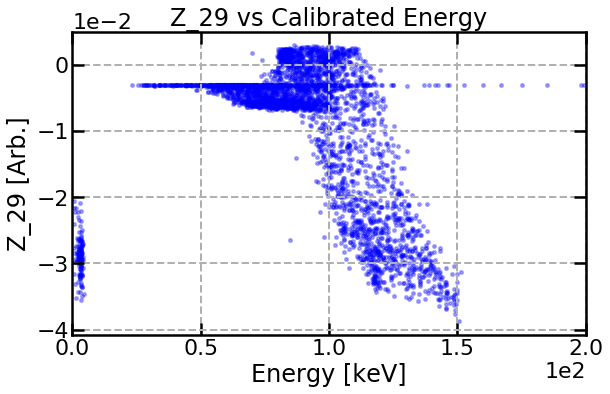

In [59]:
for ii in range(arr.shape[-1]):
    rp.scatter(labels[:, ind]*1e6, arr[:,ii], xlims=(0, 200), ms=10, lgclegend=False)
    plt.xlabel('Energy [keV]')
    plt.ylabel(f'Z_{ii} [Arb.]')
    plt.title(f'Z_{ii} vs Calibrated Energy')
    plt.tight_layout()
    if savefigs:
        plt.savefig(f'{figsavepath}Latent{ii}_vs_energy.png', dpi=400)


Make Pair plot of Laten Variables

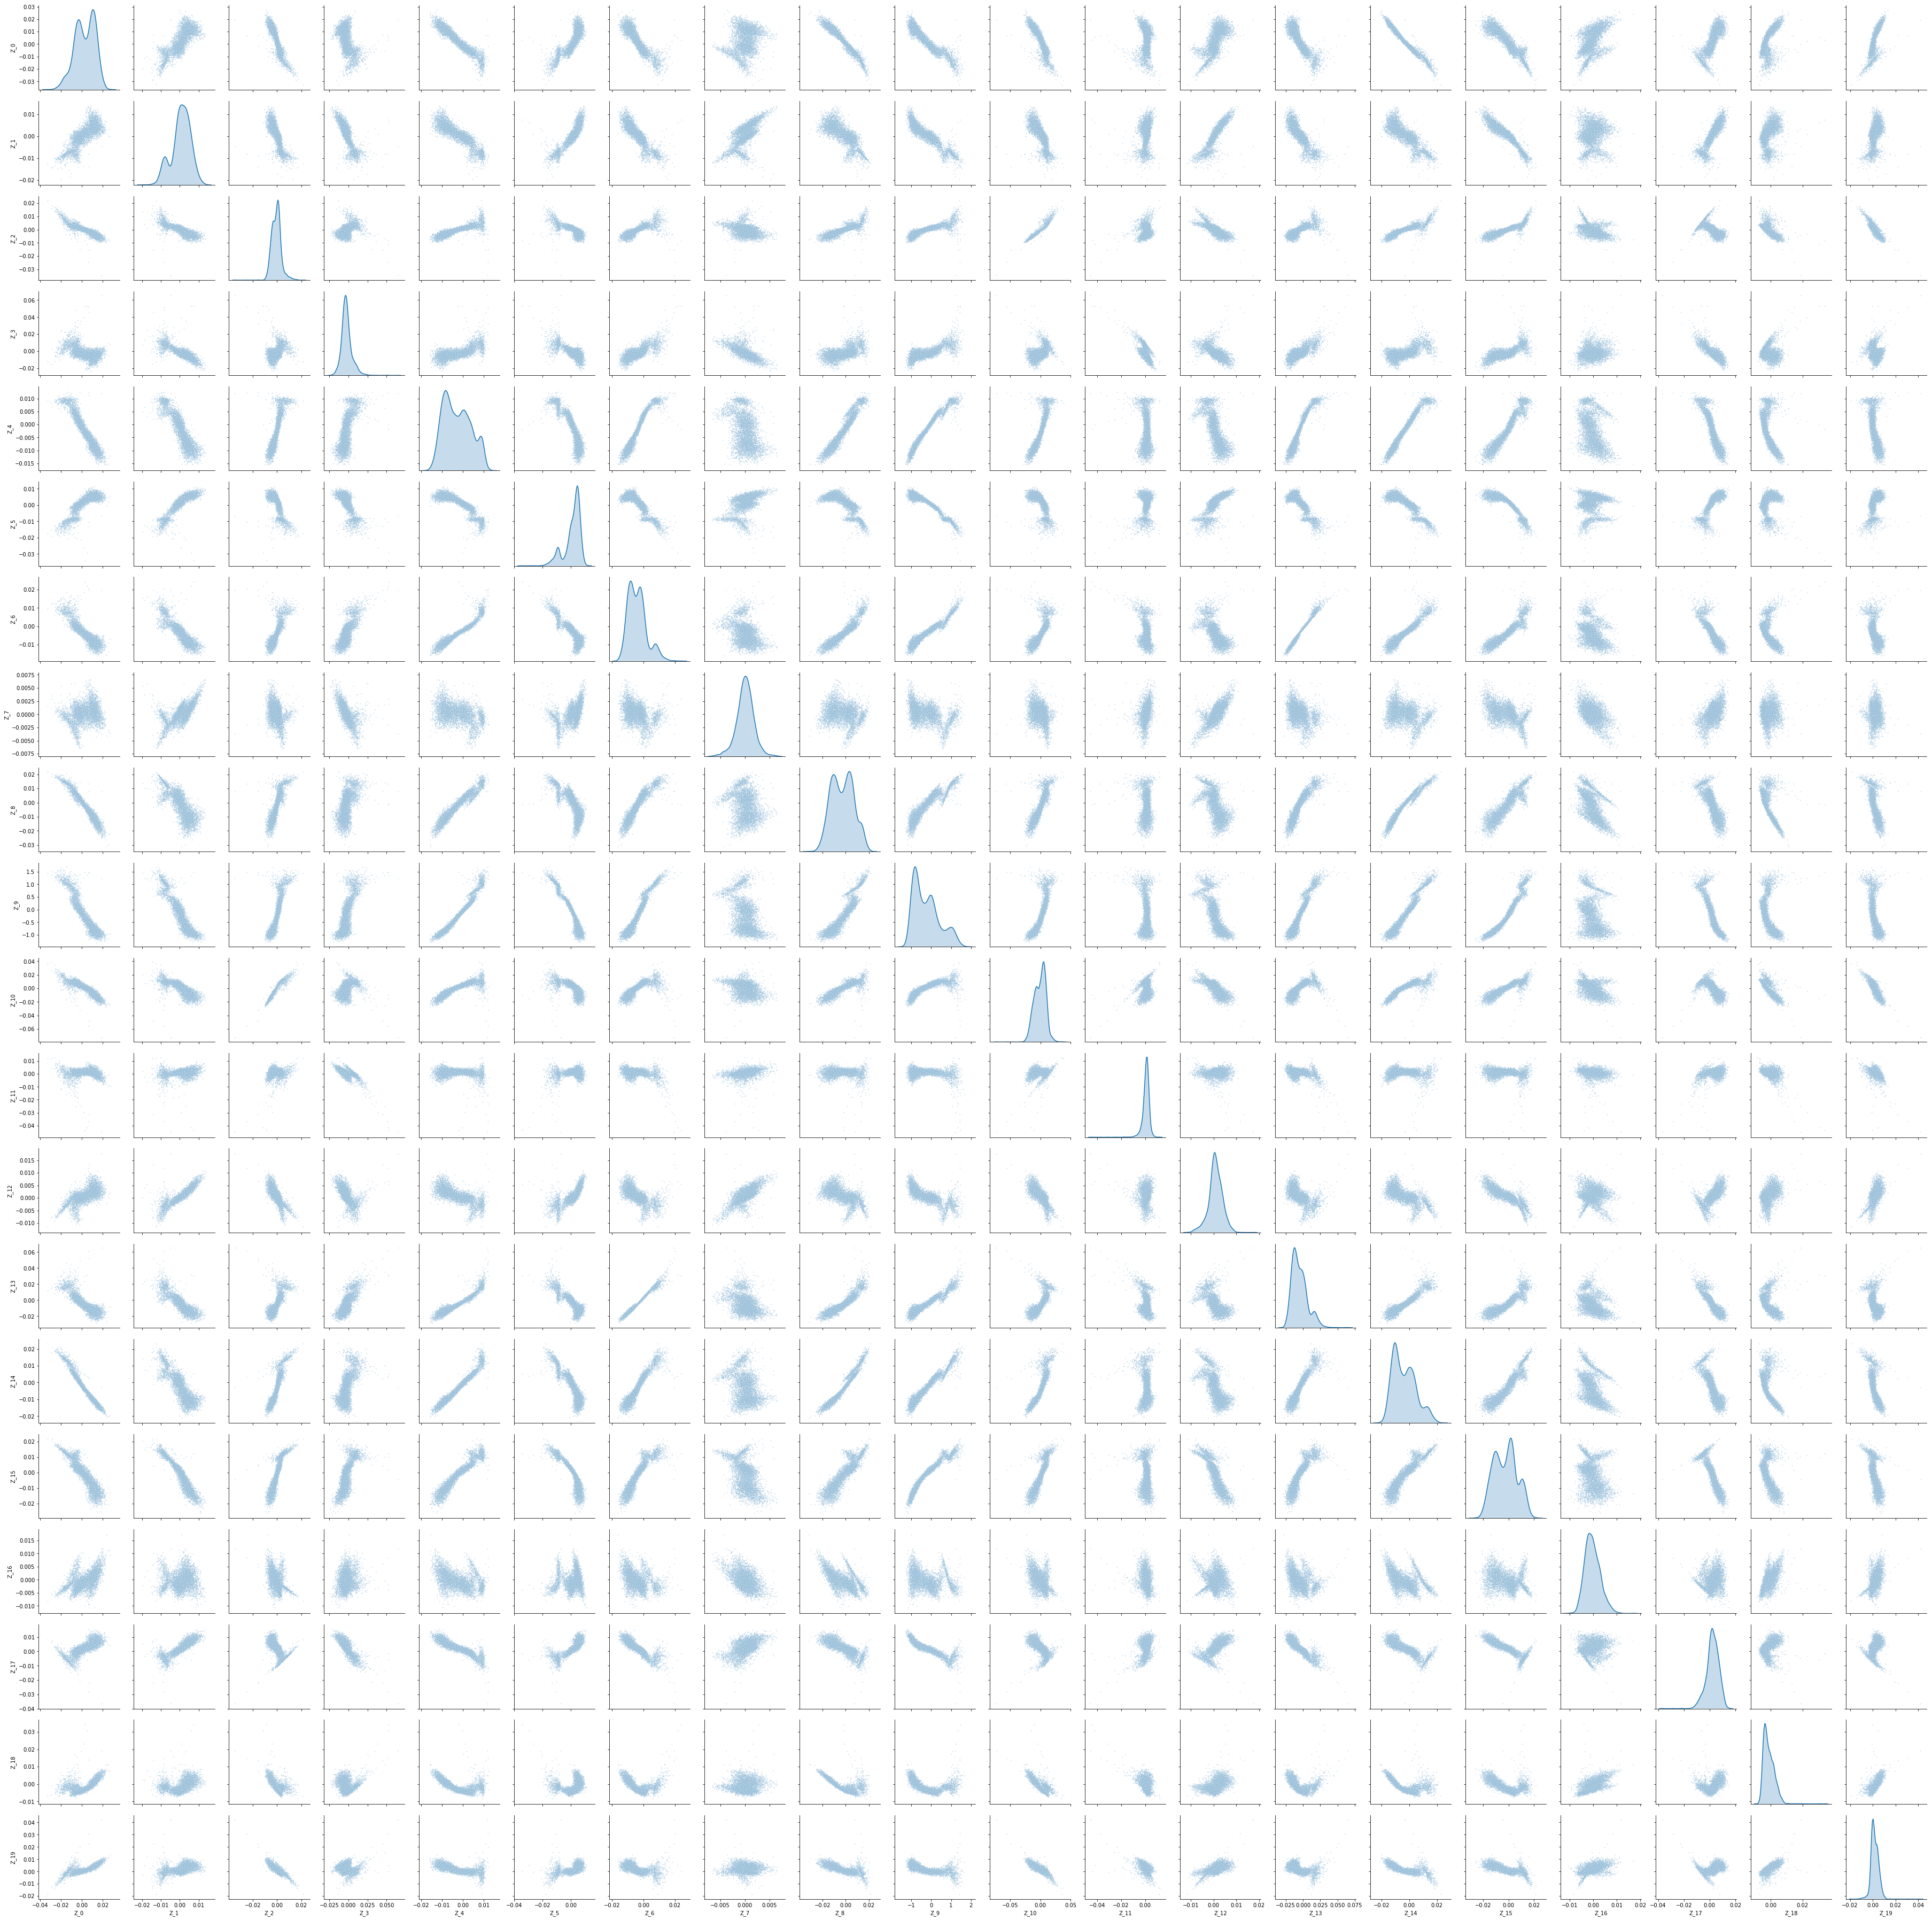

In [41]:
df = pd.DataFrame(arr, columns=[f'Z_{ii}' for ii in range(arr.shape[-1])])
sns.pairplot(df, diag_kind='kde', markers='.', plot_kws={'alpha' : .2, 'size' : 5})
if savefigs:
    plt.savefig(f'{figsavepath}latent_pairplot.png', dpi=300)

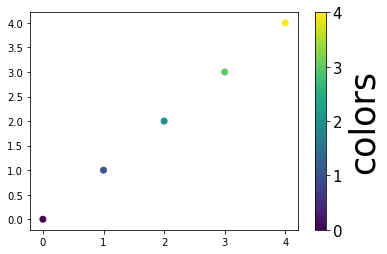

In [78]:
fig, ax = plt.subplots()
clr = ax.scatter(np.arange(5),np.arange(5),c=np.arange(5))
cbar = fig.colorbar(clr)
cbar.set_label(label='colors', size=35)
cbar.ax.tick_params(labelsize=15)

In [ ]:
/gpfs/slac/staas/fs1/supercdms/data/CDMS/UCB
